# Problem:  Predicting remaining useful life for Turbofan engines 

### Introduction

This notebook shows how to predict the remaining useful life of an industrial machine.  Predictive life and predictive maintenance are important real world topics for many industries.  This notebook will cover loading, analyzing, modeling, and deploying a machine learning model to predict the remaining useful life.  

### Background

<img src="https://aws-machine-learning-immersion-day.s3.amazonaws.com/engine_failure.gif" width="600" align="center">
<p style="text-align: center;">fan blade containment failure test</p>


Predictive maintenance is important for safety systems and systems where unexpected maintenace and downtime impacts the business objectives.  A turbofan engine is both a safety system and one where unexpected downtime impacts the operation of the airline.  

For predictive maintenance there are typically 3 approaches, it depends on how much you know about the failures and systems: 
1. Similarity - Use this approach if your data captures degridation from the healthy state to the failed state.  
2. Survival - Use this approach when you only have data from the failure event.
3. Degradation - Use this approach when you want the operation of the machine to operate above some limit threshold.

For this problem we'll look at a similarity approach using classification techniques.

### Contact

* Aaron Sengstacken
* awsaaron@amazon.com

### References
* [Predictive Maintenance - wikipedia](https://en.wikipedia.org/wiki/Predictive_maintenance)
* A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA
* https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


In [1]:
# Import Libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from datetime import datetime
import io

import boto3
import sagemaker
from sagemaker import KMeans
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac

# Data

The data for this notebook comes from a well known NASA competition in 2008.  The dataset was generated via simulation using C-MAPSS. Four different sets simulated under different combinations of operational conditions and fault modes. Recording several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

The dataset consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

### Load Data

In [4]:
# download data from URL
!wget https://ti.arc.nasa.gov/c/6/ -O CMAPSSData.zip

--2020-09-25 21:17:32--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2020-09-25 21:17:32--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘CMAPSSData.zip’

CMAPSSData.zip      100%[===================>]  11.85M  7.61MB/s    in 1.6s    

2020-09-25 21:17:34 (7.61 MB/s) - ‘CMAPSSData.zip’ saved [12425978/12425978]



In [3]:
!conda install -y -c conda-forge unzip

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - unzip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.5                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    unzip-6.0                  |       h516909a_2         141 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/linux-64::python_abi-3.7-1_cp37m
  unzip              conda-forge/linux-64::unzip-6.0-h516909a_2

The follow

In [4]:
# unpack zip file
!unzip -o CMAPSSData.zip

Archive:  CMAPSSData.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt           
  inflating: RUL_FD004.txt           
  inflating: test_FD001.txt          
  inflating: test_FD002.txt          
  inflating: test_FD003.txt          
  inflating: test_FD004.txt          
  inflating: train_FD001.txt         
  inflating: train_FD002.txt         
  inflating: train_FD003.txt         
  inflating: train_FD004.txt         


In [7]:
role = get_execution_role()
bucket = '<INSERT_BUCKET_NAME>'

The datasets don't contain any headers so we'll have to manually define those

In [8]:
cols=["unit","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19","sensor20","sensor21","sensor22","sensor23"]

In [9]:
train_df = pd.read_csv('train_FD001.txt',sep=' ',header=None,names=cols)
test_df = pd.read_csv('test_FD001.txt',sep=' ',header=None,names=cols)
rul_df = pd.read_csv('RUL_FD001.txt',header=None,names=['rul'])

In [10]:
print('Training Data')
display(train_df.head())
print('Testing Data')
display(test_df.head())
print('Remaining Useful Life Data')
display(rul_df.head())

Training Data


,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


Testing Data


,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


Remaining Useful Life Data


,rul
0,112
1,98
2,69
3,82
4,91


In [11]:
print('Training Data')
print(train_df.shape)
print('Testing Data')
print(test_df.shape)
print('Remaining Useful Life Data')
print(rul_df.shape)

Training Data
(20631, 28)
Testing Data
(13096, 28)
Remaining Useful Life Data
(100, 1)


For the remaining useful life we need to modify the test data set.  The test data set must be used to calculate the max number of cycles per engine.  This is then added to the cycles in the RUL data file to get a max cycles to failure per engine.  

In [12]:
rul_df['unit']=rul_df.index+1
test_rul = pd.DataFrame(test_df.groupby('unit')['cycle'].max()).reset_index()
rul_df['fail'] = rul_df['rul']+test_rul['cycle']
rul_df.head()

,rul,unit,fail
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [13]:
test_df = test_df.merge(rul_df,on='unit',how='left')

In [14]:
test_df['remaining_cycles'] = test_df['fail'] - test_df['cycle']
test_df.drop(columns=['rul','fail'],axis=1,inplace=True)

In [15]:
test_df.head()

,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,remaining_cycles
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN,138


In [16]:
train_df['remaining_cycles']=train_df.groupby('unit')['cycle'].transform(max)-train_df['cycle']

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unit              20631 non-null  int64  
 1   cycle             20631 non-null  int64  
 2   op1               20631 non-null  float64
 3   op2               20631 non-null  float64
 4   op3               20631 non-null  float64
 5   sensor1           20631 non-null  float64
 6   sensor2           20631 non-null  float64
 7   sensor3           20631 non-null  float64
 8   sensor4           20631 non-null  float64
 9   sensor5           20631 non-null  float64
 10  sensor6           20631 non-null  float64
 11  sensor7           20631 non-null  float64
 12  sensor8           20631 non-null  float64
 13  sensor9           20631 non-null  float64
 14  sensor10          20631 non-null  float64
 15  sensor11          20631 non-null  float64
 16  sensor12          20631 non-null  float6

**Take Away:** Data was loaded successfully, we have some null values in the last two sensors that we'll need to address

### Data Exploration and Preparation

**Questions:**

1. How many engines are in the dataset?
2. How long was each engine run?
3. What is the distribution of total cycles on each engine?
4. What are the operational settings for the engines and how do they vary?

In [18]:
# Question 1 - How many engines are in the dataset?
train_df['unit'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [19]:
train_df.head()

,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,remaining_cycles
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187


In [20]:
# Question 2 - How long was each engine run for?
max_cycles = train_df.groupby('unit')['cycle'].max()

(0, 101)

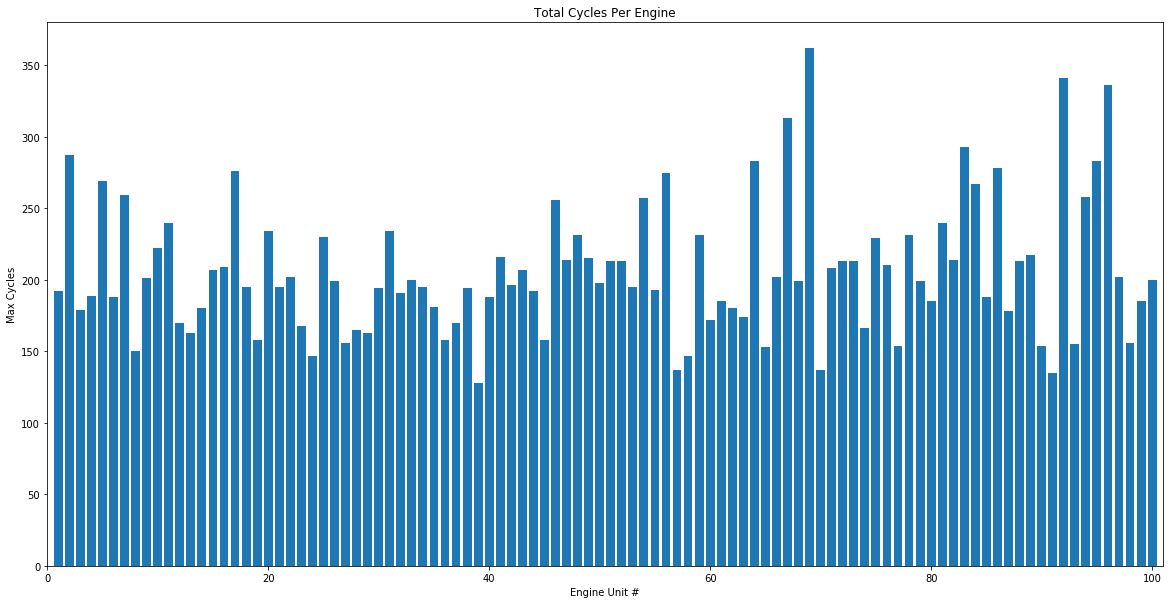

In [21]:
fig,ax = plt.subplots(figsize=(20,10))
plt.bar(max_cycles.index,max_cycles.values)
plt.xlabel('Engine Unit #')
plt.ylabel('Max Cycles')
plt.title('Total Cycles Per Engine')
plt.xlim((0,101))

Text(0, 0.5, 'Count')

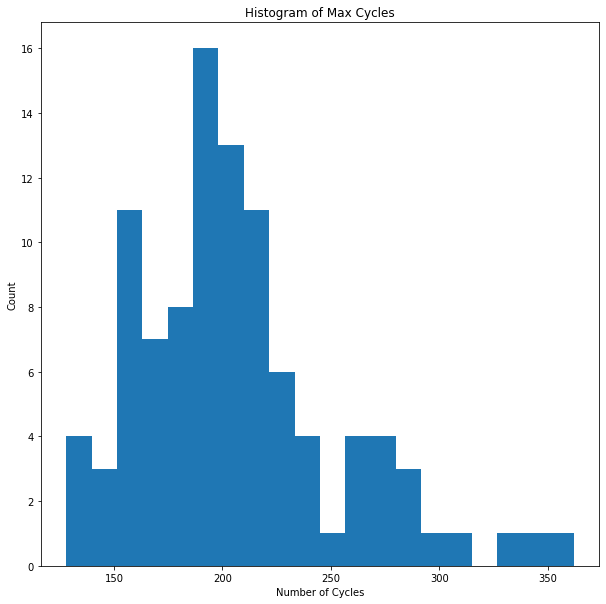

In [22]:
# Question 3 - What is the distribution of cycles across engines?
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(max_cycles.values,bins=20)
plt.title('Histogram of Max Cycles')
plt.xlabel('Number of Cycles')
plt.ylabel('Count')

In [23]:
max_cycles.describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

count    20631.000000
mean        -0.000009
std          0.002187
min         -0.008700
25%         -0.001500
50%          0.000000
75%          0.001500
max          0.008700
Name: op1, dtype: float64

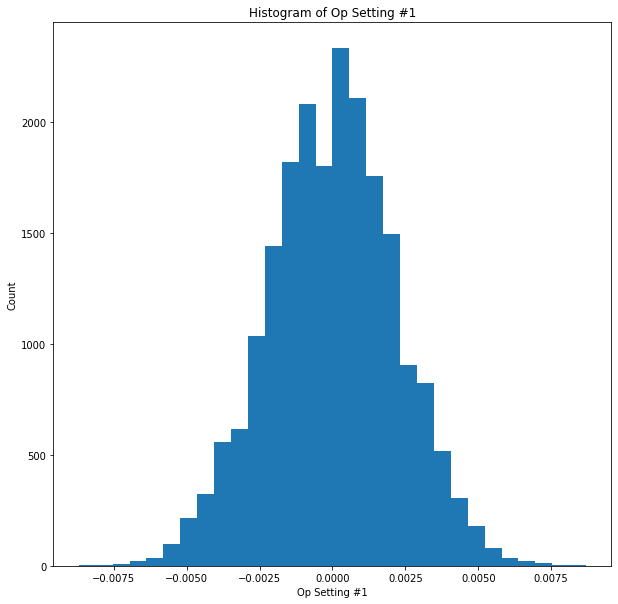

In [24]:
#Question 4. What are the operational settings for the engines and how do they vary?
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op1'].values,bins=30)
plt.title('Histogram of Op Setting #1')
plt.xlabel('Op Setting #1')
plt.ylabel('Count')
train_df['op1'].describe()

count    20631.000000
mean         0.000002
std          0.000293
min         -0.000600
25%         -0.000200
50%          0.000000
75%          0.000300
max          0.000600
Name: op2, dtype: float64

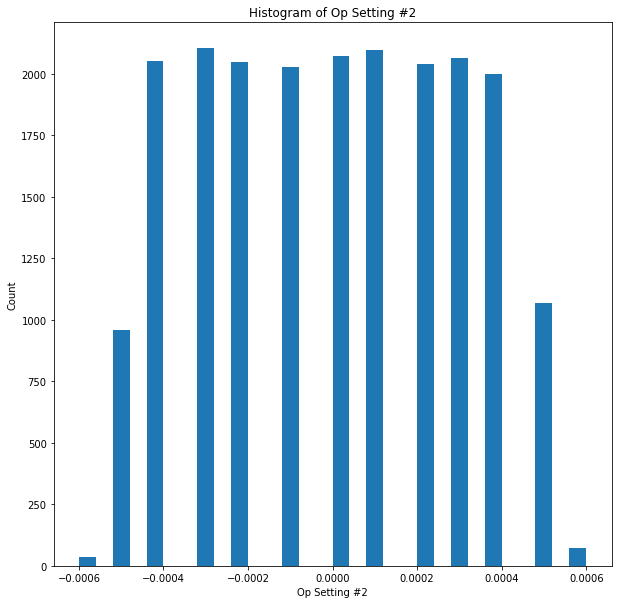

In [25]:
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op2'].values,bins=30)
plt.title('Histogram of Op Setting #2')
plt.xlabel('Op Setting #2')
plt.ylabel('Count')
train_df['op2'].describe()

count    20631.0
mean       100.0
std          0.0
min        100.0
25%        100.0
50%        100.0
75%        100.0
max        100.0
Name: op3, dtype: float64

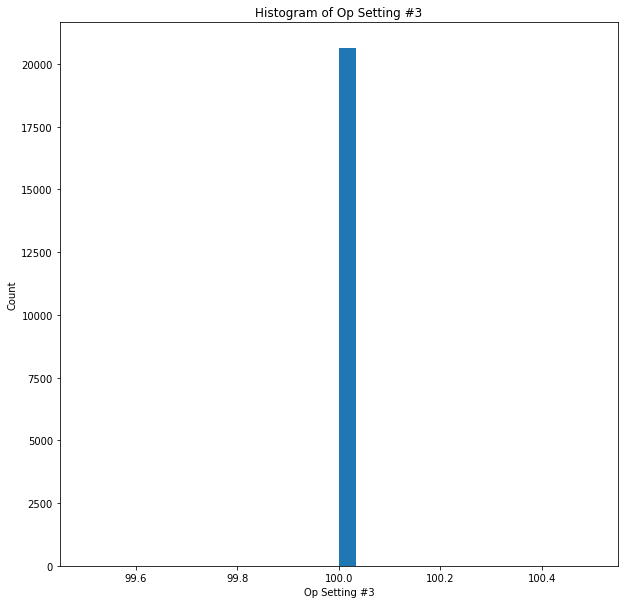

In [26]:
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op3'].values,bins=30)
plt.title('Histogram of Op Setting #3')
plt.xlabel('Op Setting #3')
plt.ylabel('Count')
train_df['op3'].describe()

**Take Away** The Op3 setting is constant for all data in the dataset, suggest removal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d99cb4590>,
      dtype=object)

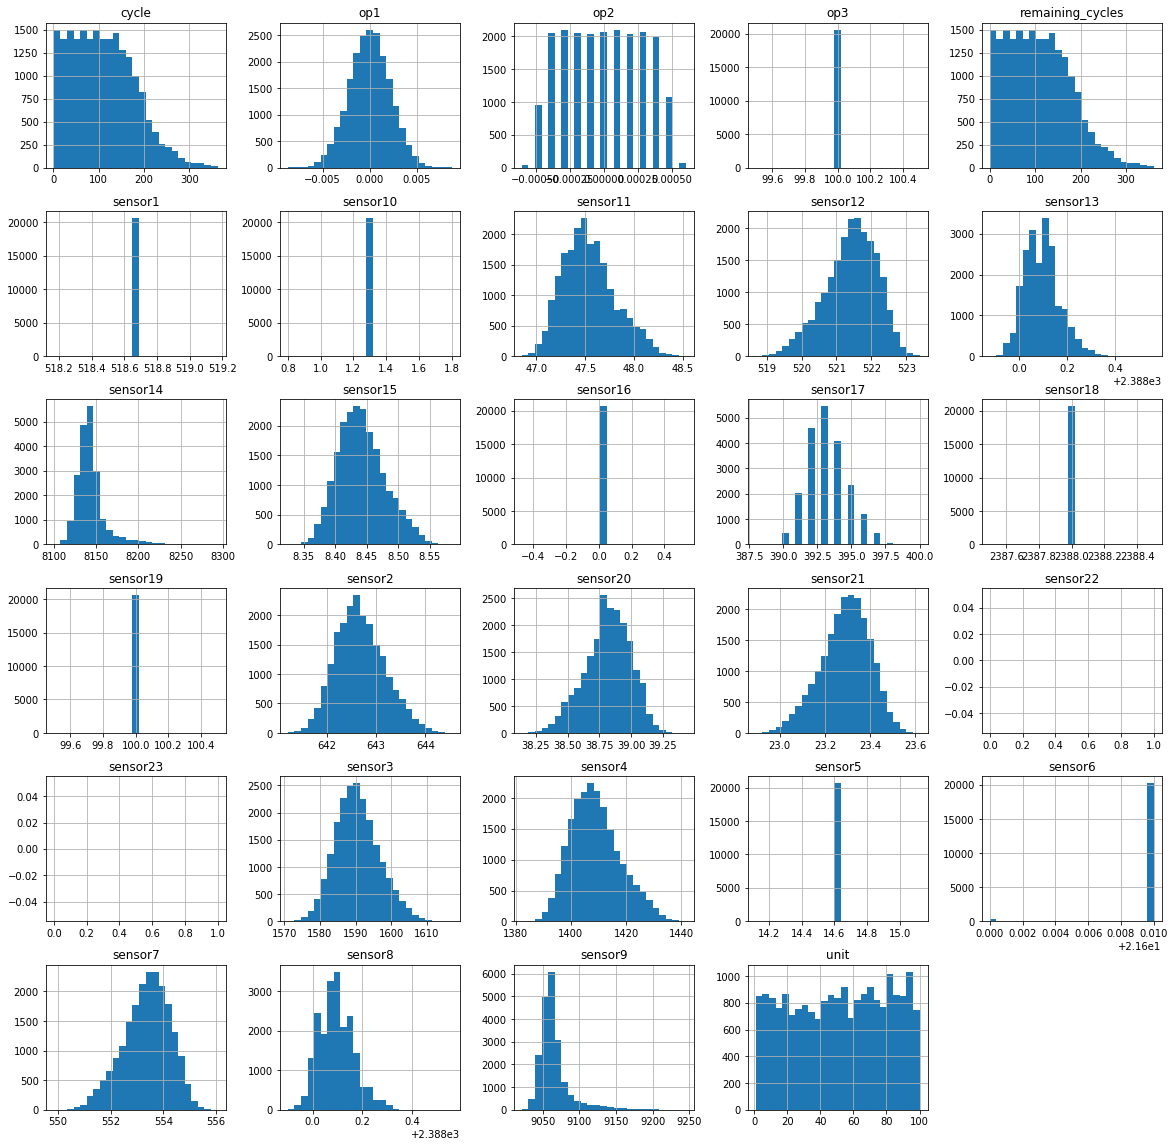

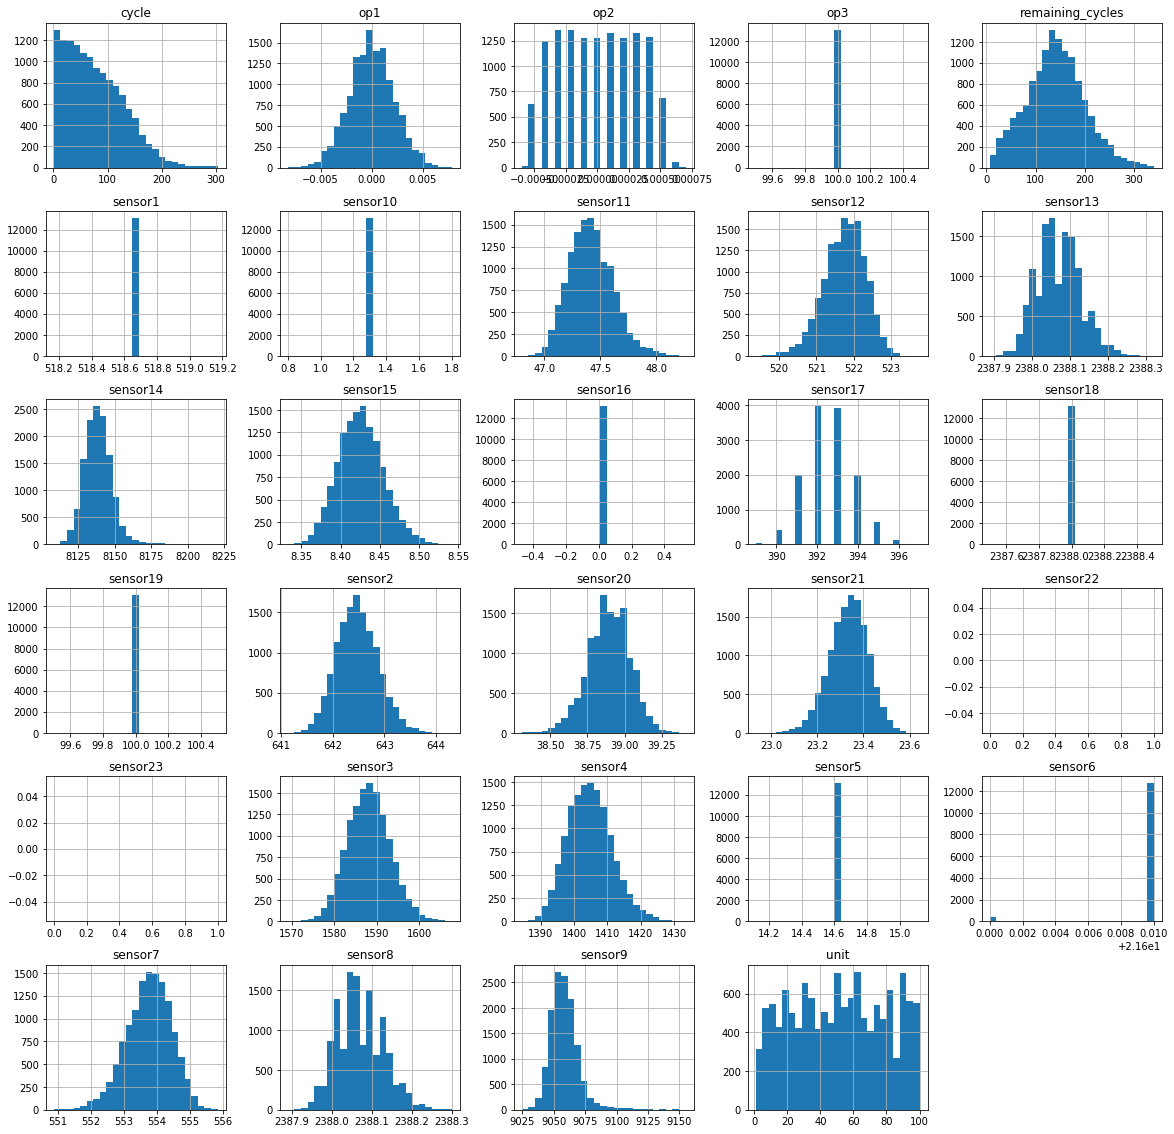

In [27]:
train_df.hist(figsize=(20,20),bins=25)
test_df.hist(figsize=(20,20),bins=25)

In [28]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


**Take Away** 
1. Sensor 1, 5, 6, 10, 16, 18, 19, Op3 have constant values across the dataset, suggest removal.  
2. Sensor 22, 23 are missing, suggest removal

Note:  Unit and Cycle histograms are not informative since they contain the engine number and cycle (recall from above that max cycle per engine was useful)

In [29]:
drop_cols = ['unit','cycle','op3','sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19','sensor22','sensor23']

In [30]:
train_df.drop(drop_cols,axis=1,inplace=True)

In [31]:
test_df.drop(drop_cols,axis=1,inplace=True)

#### Prepare Target Variable

For this task we want to predict that the engine is near failure, before it fails.  To do that we will convert the cycle count column to remaining cycles.  Next, we will add an additonal column that is a binary variable when the engine has X remaining cycles left.  X can be defined by the user.  In this example we will use 20 remaining cycles as the 

In [32]:
cycle_limit = 40
train_df['failed'] = train_df['remaining_cycles'].apply(lambda x: 1 if x <= cycle_limit else 0)
test_df['failed'] = test_df['remaining_cycles'].apply(lambda x: 1 if x <= cycle_limit else 0)

In [33]:
print('Total number of failed cases in training dataset:  '+str(train_df['failed'].sum()))
print('Fraction of total in training dataset:  '+str(train_df['failed'].sum()/train_df['failed'].count()))

Total number of failed cases in training dataset:  4100
Fraction of total in training dataset:  0.19873006640492463


In [34]:
print('Total number of failed cases in test dataset:  '+str(test_df['failed'].sum()))
print('Fraction of total in test dataset:  '+str(test_df['failed'].sum()/test_df['failed'].count()))

Total number of failed cases in test dataset:  596
Fraction of total in test dataset:  0.045510079413561395


#### Missing Values

In [35]:
train_df.isnull().values.any()

False

In [36]:
test_df.isnull().values.any()

False

In [37]:
train_df.shape

(20631, 18)

In [38]:
test_df.shape

(13096, 18)

In [39]:
train_df.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
0,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0
1,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0
2,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0
3,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0
4,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0


In [40]:
test_df.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
0,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142,0
1,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141,0
2,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140,0
3,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139,0
4,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138,0


#### Shuffle / Randomize

In [41]:
# randomize - optional
train_df = train_df.sample(frac=1,random_state=1234).reset_index(drop=True)

#### Split Dataset

In [85]:
# split
np.random.seed(1234)
rand_split = np.random.rand(len(train_df))
train_bool = rand_split < 0.8
val_bool = (rand_split >= 0.8)

train_df_split = train_df[train_bool]
val_df_split = train_df[val_bool]

In [43]:
train_df_split

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
0,0.0019,0.0002,642.58,1586.81,1397.25,553.96,2388.07,9066.89,47.22,522.35,2388.00,8140.88,8.4223,393,38.96,23.3780,169,0
1,0.0001,0.0001,643.20,1591.64,1410.92,552.21,2388.19,9055.31,47.74,520.48,2388.15,8137.26,8.4588,393,38.70,23.1894,112,0
2,-0.0032,0.0004,642.12,1587.96,1394.48,554.26,2388.01,9060.24,47.31,522.53,2388.03,8151.48,8.4488,393,38.96,23.3425,151,0
4,0.0003,-0.0002,642.71,1593.85,1409.66,552.72,2388.12,9061.56,47.64,521.37,2388.06,8141.76,8.4357,394,38.71,23.1922,87,0
5,-0.0019,-0.0001,642.69,1591.62,1409.32,553.40,2388.14,9046.43,47.52,521.21,2388.13,8128.54,8.4511,393,38.82,23.2766,236,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20625,-0.0005,0.0005,642.87,1588.19,1412.54,553.11,2388.15,9040.94,47.45,521.50,2388.17,8119.46,8.4238,394,38.91,23.3140,121,0
20626,0.0009,-0.0000,643.70,1597.51,1423.19,551.64,2388.27,9066.43,48.00,519.61,2388.15,8142.79,8.5116,398,38.51,23.1990,15,1
20627,-0.0014,-0.0004,642.53,1598.55,1409.81,553.46,2387.99,9116.37,47.36,521.07,2388.02,8189.63,8.4457,393,38.77,23.2795,46,0
20628,-0.0036,-0.0003,641.95,1588.72,1402.76,554.18,2388.00,9062.50,47.28,522.37,2388.03,8145.59,8.4574,391,39.07,23.3382,165,0


In [44]:
# rearrange the columns so that the target is the first column
train = pd.concat([train_df_split['failed'],train_df_split.drop(['failed'],axis=1)],axis=1)
val = pd.concat([val_df_split['failed'],val_df_split.drop(['failed'],axis=1)],axis=1)

In [45]:
#train_y = train_df_split['failed']
train.drop(columns=['remaining_cycles'],axis=1,inplace=True)

#val_y = val_df_split['failed']
val.drop(columns=['remaining_cycles'],axis=1,inplace=True)

#### Save and Upload Data

In [46]:
# save to CSV
train.to_csv('train.csv',index=False, header=False)
val.to_csv('val.csv',index=False, header=False)

In [47]:
!ls

 CMAPSSData.zip			    Untitled.ipynb   train.csv
'Damage Propagation Modeling.pdf'   pm		     train_FD001.txt
 RUL_FD001.txt			    readme.txt	     train_FD002.txt
 RUL_FD002.txt			    test_FD001.txt   train_FD003.txt
 RUL_FD003.txt			    test_FD002.txt   train_FD004.txt
 RUL_FD004.txt			    test_FD003.txt   val.csv
'TurbofanRUL(1).ipynb'		    test_FD004.txt


In [48]:
# upload to s3
boto3.Session().resource('s3').Bucket(bucket).Object('train.csv').upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object('val.csv').upload_file('val.csv')

# Modeling

### XGBoost

#### Model Selection

In [51]:
boto3.Session().region_name

'us-east-1'

In [54]:
container = sagemaker.image_uris.retrieve('xgboost',boto3.Session().region_name,'latest')
print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest


In [56]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/train.csv'.format(bucket), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/val.csv'.format(bucket), content_type='csv')

#### Model Training Config

In [57]:
# Create a training job name
job_name = 'turbofan-xgboost-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
print('Job Name: {}'.format(job_name))

# Here is where the model artifact will be stored
output_location = 's3://{}/'.format(bucket)

Job Name: turbofan-xgboost-job-20200925213115


In [59]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eta=0.1,
                        objective='binary:logistic',
                        num_round=100)


data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}

#### Model Training

In [60]:
xgb.fit(data_channels, job_name=job_name)

2020-09-25 21:32:42 Starting - Starting the training job...
2020-09-25 21:32:44 Starting - Launching requested ML instances.........
2020-09-25 21:34:17 Starting - Preparing the instances for training......
2020-09-25 21:35:20 Downloading - Downloading input data...
2020-09-25 21:35:58 Training - Downloading the training image..Arguments: train
[2020-09-25:21:36:20:INFO] Running standalone xgboost training.
[2020-09-25:21:36:20:INFO] File size need to be processed in the node: 2.27mb. Available memory size in the node: 8487.98mb
[2020-09-25:21:36:20:INFO] Determined delimiter of CSV input is ','
[21:36:20] S3DistributionType set as FullyReplicated
[21:36:20] 16476x16 matrix with 263616 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-25:21:36:20:INFO] Determined delimiter of CSV input is ','
[21:36:20] S3DistributionType set as FullyReplicated
[21:36:20] 4155x16 matrix with 66480 entries loaded from /opt/ml/input/data/validation?format=csv&lab

In [61]:
print('Here is the location of the trained model: {}/{}/model.tar.gz'.format(output_location, job_name))

Here is the location of the trained model: s3://temp-sengstacken//turbofan-xgboost-job-20200925213115/model.tar.gz


#### Training Evaluation

In [62]:
# plot validation and training progress
client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_log(model):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    val = []
    train = []
    iteration = []
    for e in cw_log['events']:
        msg = e['message']
        if 'train-error' in msg:
            msg = msg.split('#011')
            #print(msg)
            train.append(float(msg[1].split(':')[-1]))
            val.append(float(msg[2].split(':')[-1]))
            iteration.append(float(msg[0][1:-1]))

    fig, ax = plt.subplots()
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    train_plot,   = ax.plot(iteration,   train,   label='train')
    val_plot,   = ax.plot(iteration,   val,   label='validation')
    plt.legend(handles=[train_plot,val_plot])
    plt.show()

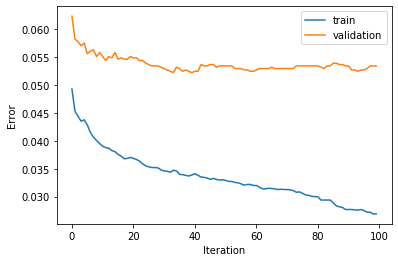

In [63]:
plot_log(xgb)

# Model Deployment

Now that we've trained the xgboost algorithm on our data, let's deploy a model that's hosted behind a real-time endpoint.

In [64]:
%%time
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!CPU times: user 253 ms, sys: 11.1 ms, total: 264 ms
Wall time: 7min 33s


Evaluate

There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values. In this case, we're predicting whether the engine behavior is in the predictive maintenance interval (1) or not (0).  The evaluation of these predictions produces a simple confusion matrix.

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as as a CSV.  To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.

### Evaluation

In [70]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [71]:
test_df.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
0,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142,0
1,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141,0
2,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140,0
3,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139,0
4,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138,0


In [73]:
test_df.iloc[[10]]

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
10,0.0007,-0.0004,642.04,1581.03,1403.83,554.69,2388.04,9051.67,47.23,521.95,2388.06,8132.38,8.3919,391,39.06,23.3609,132,0


In [72]:
xgb_predictor.predict(test_df.drop(['remaining_cycles', 'failed'], axis=1).iloc[[10]].values)

b'0.000106530707853'

In [74]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [75]:
predictions = predict(test_df.drop(['remaining_cycles', 'failed'], axis=1).to_numpy())

In [76]:
predictions.shape

(13096,)

In [78]:
val_predictions = predict(val.drop(['failed'], axis=1).to_numpy())

In [79]:
val_predictions.shape

(4155,)

In [80]:
print('Val Dataset Results')
pd.crosstab(index=val['failed'], columns=np.round(val_predictions), rownames=['actuals'], colnames=['predictions'])

Val Dataset Results


predictions,0.0,1.0
actuals,,
0,3230,82
1,140,703


In [81]:
# evaluate the model
score = f1_score(val['failed'], np.round(val_predictions))
print('F-Score: %.5f' % score)

F-Score: 0.86364


In [82]:
print('Test Dataset Results')
pd.crosstab(index=test_df['failed'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

Test Dataset Results


predictions,0.0,1.0
actuals,,
0,12420,80
1,233,363


In [86]:
# evaluate the model
score = f1_score(test_df['failed'], np.round(predictions))
print('F-Score: %.5f' % score)

F-Score: 0.69875


In [87]:
from sklearn.metrics import classification_report
print(classification_report(test_df['failed'], np.round(predictions)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12500
           1       0.82      0.61      0.70       596

    accuracy                           0.98     13096
   macro avg       0.90      0.80      0.84     13096
weighted avg       0.97      0.98      0.97     13096



### Threshold

Our application above had a class imbalance.  While there are numerous sampling options we could investigate to boost the undersampled class, another approach is to optimize the cut off threshold.  See this great blog post for more information - https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [88]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [89]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(val['failed'], to_labels(val_predictions, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.436, F-Score=0.86962


In [90]:
pd.crosstab(index=test_df['failed'], columns=to_labels(predictions,0.425), rownames=['actuals'], colnames=['predictions'])

predictions,0,1
actuals,,
0,12392,108
1,214,382


# Clean Up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [92]:
xgb_predictor.delete_endpoint()

# Diving Deeper

This binary classification problem served as a good overview of the AWS services and tools that enable machine learning for all developers, however, there are many other approaches that could be used to study the problem of predictive maintenance.  For this example, the data for an aircraft engine is a time series.  We can use the time series data to predict how much remaining life exists in the engine.  Below is a link to time series analysis using MXNet recurrent neural networks.

https://github.com/awslabs/predictive-maintenance-using-machine-learning/blob/master/source/notebooks/sagemaker_predictive_maintenance.ipynb
